In [2]:
import matplotlib.pyplot as plt
import numpy as np
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L
from gridworld import GridWorld

In [3]:
def one_hot(state):
    HEIGHT, WIDTH = 3, 4
    vec = np.zeros(HEIGHT * WIDTH, dtype=np.float32)
    y, x = state
    idx = WIDTH * y + x
    vec[idx] = 1.0
    return vec[np.newaxis, :]

In [4]:
class QNet(Model):
    def __init__(self):
        super().__init__()
        self.l1 = L.Linear(100)  # 중간층의 크기
        self.l2 = L.Linear(4)    # 행동의 크기(가능한 행동의 개수)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [5]:
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.lr = 0.01
        self.epsilon = 0.1
        self.action_size = 4

        self.qnet = QNet()                        # 신경망 초기화
        self.optimizer = optimizers.SGD(self.lr)  # 옵티마이저 생성
        self.optimizer.setup(self.qnet)           # 옵티마이저에 신경망 등록

    def get_action(self, state_vec):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            qs = self.qnet(state_vec)
            return qs.data.argmax()

    def update(self, state, action, reward, next_state, done):
        # 다음 상태에서 최대가 되는 Q 함수의 값(next_q) 계산
        if done:  # 목표 상태에 도달
            next_q = np.zeros(1)  # [0.]  # [0.] (목표 상태에서의 Q 함수는 항상 0)
        else:     # 그 외 상태
            next_qs = self.qnet(next_state)
            next_q = next_qs.max(axis=1)
            next_q.unchain()  # next_q를 역전파 대상에서 제외

        # 목표
        target = self.gamma * next_q + reward
        # 현재 상태에서의 Q 함수 값(q) 계산
        qs = self.qnet(state)
        q = qs[:, action]
        # 목표(target)와 q의 오차 계산
        loss = F.mean_squared_error(target, q)

        # 역전파 → 매개변수 갱신
        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

        return loss.data

In [15]:
env = GridWorld()
agent = QLearningAgent()

In [16]:
episodes = 1000  # 에피소드 수
loss_history = []

In [17]:
for episode in range(episodes):
    state = env.reset()
    state = one_hot(state)
    total_loss, cnt = 0, 0
    done = False

    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        next_state = one_hot(next_state)

        loss = agent.update(state, action, reward, next_state, done)
        total_loss += loss
        cnt += 1
        state = next_state

    average_loss = total_loss / cnt
    loss_history.append(average_loss)


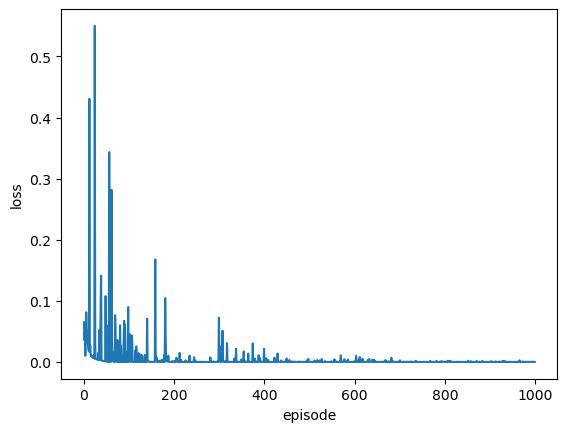

In [18]:
# [그림 7-14] 에피소드별 손실 추이
plt.xlabel('episode')
plt.ylabel('loss')
plt.plot(range(len(loss_history)), loss_history)
plt.show()

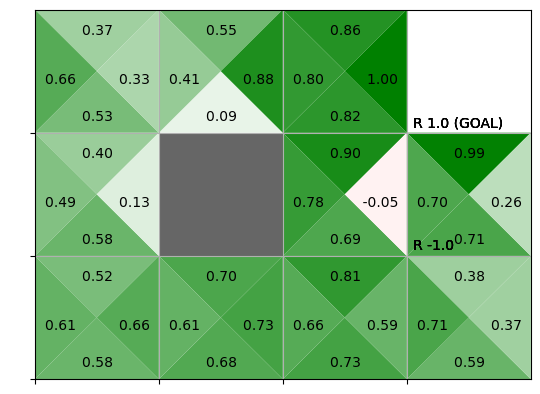

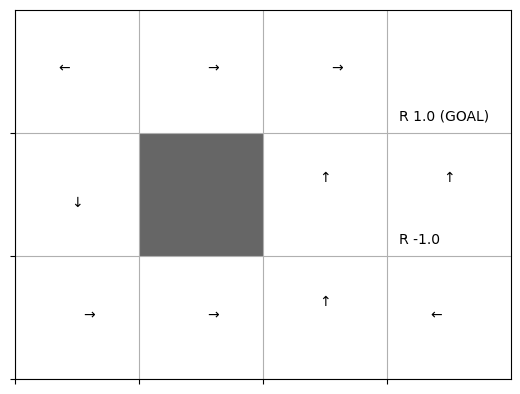

In [19]:
# [그림 7-15] 신경망을 이용한 Q 러닝으로 얻은 Q 함수와 정책
Q = {}
for state in env.states():
    for action in env.action_space:
        q = agent.qnet(one_hot(state))[:, action]
        Q[state, action] = float(q.data)
env.render_q(Q)